<a href="https://colab.research.google.com/github/johanjun/kaggle_cassava_leaf/blob/main/Cassava_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library import

In [ ]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et
import json
import pprint

# Data load

In [ ]:
%cd /content/drive/MyDrive/Cassava_Leaf

/content/drive/MyDrive/Cassava_Leaf


In [ ]:
os.getcwd()

'/content/drive/MyDrive/Cassava_Leaf'

In [ ]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')
image_dir = os.path.join(data_dir, 'train_images')

In [ ]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg'] #확장자 분리
print(len(image_files))

21397


In [ ]:
image_files[:10]

['787914923.jpg',
 '822641071.jpg',
 '810351903.jpg',
 '813744167.jpg',
 '821592762.jpg',
 '803715275.jpg',
 '816689138.jpg',
 '787415998.jpg',
 '813217011.jpg',
 '793206643.jpg']

In [ ]:
with open(os.path.join(data_dir, 'label_num_to_disease_map.json')) as f:
    mapping = json.loads(f.read())
    pprint.pprint(mapping)

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}


## data split by label

In [ ]:
with open(os.path.join(data_dir, 'train.csv')) as f:
    df_train = pd.read_csv(f)

df_train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
df1 = df_train[df_train.label==1]
df1.label.value_counts()

1    2189
Name: label, dtype: int64

In [ ]:
df0 = df_train[df_train.label==0]
df0.label.value_counts()

0    1087
Name: label, dtype: int64

In [ ]:
df2 = df_train[df_train.label==2]
df2.label.value_counts()

2    2386
Name: label, dtype: int64

In [ ]:
df3 = df_train[df_train.label==3]
df3.label.value_counts()

3    13158
Name: label, dtype: int64

In [ ]:
df4 = df_train[df_train.label==4]
df4.label.value_counts()

4    2577
Name: label, dtype: int64

In [ ]:
len(pd.concat([df0, df1, df2, df3, df4])) == len(df_train)

True

In [ ]:
df1.head()

,image_id,label
2,100042118.jpg,1
3,1000723321.jpg,1
12,1002088496.jpg,1
22,1004389140.jpg,1
41,1008142548.jpg,1


In [ ]:
df0_shuffled = df0.sample(frac=1).reset_index(drop=True)
df1_shuffled = df1.sample(frac=1).reset_index(drop=True)
df2_shuffled = df2.sample(frac=1).reset_index(drop=True)
df3_shuffled = df3.sample(frac=1).reset_index(drop=True)
df4_shuffled = df4.sample(frac=1).reset_index(drop=True)

In [ ]:
#train, val
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [ ]:
cnt = 0
for image_file in df0_shuffled.image_id.to_list():
  image_path = os.path.join(image_dir, image_file)
  if cnt <= 0.8*len(df0_shuffled.image_id.to_list()):
    cpath = train_dir
  else:
    cpath = val_dir
  shutil.copy(image_path, cpath)
  cnt += 1

In [ ]:
df_shuffled_list = [df1_shuffled, df2_shuffled, df3_shuffled, df4_shuffled]
for l in df_shuffled_list:
  cnt = 0
  print(l, " start!")
  for image_file in l.image_id.to_list():
    image_path = os.path.join(image_dir, image_file)
    if cnt <= 0.8*len(l.image_id.to_list()):
      cpath = train_dir
    else:
      cpath = val_dir
    shutil.copy(image_path, cpath)
    cnt += 1
    if cnt%100 == 0:
      print(cnt, 'complete.')

            image_id  label
0     3507114461.jpg      1
1     1909629301.jpg      1
2       76610968.jpg      1
3     4254996610.jpg      1
4     3770952591.jpg      1
...              ...    ...
2184  1875533805.jpg      1
2185  2425193162.jpg      1
2186  2995113861.jpg      1
2187   379373523.jpg      1
2188  2182500020.jpg      1

[2189 rows x 2 columns]  start!
100 complete.
200 complete.
300 complete.
400 complete.
500 complete.
600 complete.
700 complete.
800 complete.
900 complete.
1000 complete.
1100 complete.
1200 complete.
1300 complete.
1400 complete.
1500 complete.
1600 complete.
1700 complete.
1800 complete.
1900 complete.
2000 complete.
2100 complete.
            image_id  label
0     3826775864.jpg      2
1     1393783706.jpg      2
2      766908244.jpg      2
3     1792425947.jpg      2
4     3743464955.jpg      2
...              ...    ...
2381  4079242692.jpg      2
2382  2753152635.jpg      2
2383  1608857677.jpg      2
2384  2694534101.jpg      2
2385    22116035.

In [ ]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

print(len(train_images), len(val_images))

17119 4277


# TFRecord

In [ ]:
IMG_SIZE = 224

In [ ]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [ ]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
train_images[777]

'2185298493.jpg'

In [ ]:
file_name = train_images[777]
file_name

'2185298493.jpg'

In [ ]:
class_num = int(df_train[df_train.image_id == file_name].label)
class_num

4

In [ ]:
class_name = mapping[str(class_num)]
class_name

'Healthy'

In [ ]:
## Training data로 tfrecord 만들기
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    file_name = train_file
    class_num = int(df_train[df_train.image_id == file_name].label)
    class_name = mapping[str(class_num)]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1
    print(train_file)
    if n_train % 1000 == 0:
      print(n_train, ' completed.')
writer_train.close()
print(n_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3750670092.jpg
3237298284.jpg
1221664353.jpg
2652914186.jpg
58446146.jpg
3279028248.jpg
4275284230.jpg
947554618.jpg
3855303383.jpg
3764673411.jpg
4061670540.jpg
862068300.jpg
4044329664.jpg
2940017595.jpg
3120878352.jpg
2348678150.jpg
2855622883.jpg
2059469005.jpg
3491333559.jpg
1424930187.jpg
804903970.jpg
4063867745.jpg
1969558771.jpg
4261141445.jpg
81164598.jpg
3184329827.jpg
4222447484.jpg
3115800767.jpg
114198015.jpg
1427622404.jpg
2431664846.jpg
1779392681.jpg
1215008377.jpg
2381662575.jpg
2401928784.jpg
2961976125.jpg
3965169748.jpg
3635783291.jpg
1860678801.jpg
442179764.jpg
686316627.jpg
287262008.jpg
2564359652.jpg
3557261189.jpg
2401953205.jpg
328474315.jpg
3613817114.jpg
2317789476.jpg
2306755781.jpg
605816056.jpg
2158845807.jpg
267769333.jpg
2339596137.jpg
679522078.jpg
3518069486.jpg
536966524.jpg
3273515631.jpg
2422491518.jpg
1342109684.jpg
2558884155.jpg
1601382474.jpg
2707336069.jpg
1415152677.jpg
1079514795.jpg
4279471194.jpg
14928

UnidentifiedImageError: ignored

In [ ]:
train_files.index('102485576.jpg')

16470

In [ ]:
print(n_train)

16470


In [ ]:
## Training data로 tfrecord 만들기
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files[16471:]:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    file_name = train_file
    class_num = int(df_train[df_train.image_id == file_name].label)
    class_name = mapping[str(class_num)]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1
    print(train_file)
    if n_train % 1000 == 0:
      print(n_train, ' completed.')
writer_train.close()
print(n_train)

2034410033.jpg
164144958.jpg
2819885255.jpg
2109198789.jpg
3950261672.jpg
3939876859.jpg
3882757126.jpg
1521850100.jpg
410556634.jpg
3368505651.jpg
770243890.jpg
1541989559.jpg
785146800.jpg
2842557158.jpg
4172480899.jpg
2500976609.jpg
1876922129.jpg
1797773732.jpg
3556578053.jpg
253418223.jpg
2343776715.jpg
3708657911.jpg
3469093921.jpg
2599658053.jpg
3288990051.jpg
1463935986.jpg
2872979804.jpg
2809101504.jpg
4059009090.jpg
1981073260.jpg
3686283354.jpg
1836048821.jpg
3253305739.jpg
4282010677.jpg
3454534975.jpg
1850723562.jpg
2740084860.jpg
610968546.jpg
2462319978.jpg
58780369.jpg
1813889006.jpg
1609948219.jpg
506774842.jpg
3263547515.jpg
2998136552.jpg
3269646431.jpg
965919968.jpg
1584698721.jpg
429832892.jpg
2376221892.jpg
3858873251.jpg
1328372449.jpg
986965803.jpg
1003888281.jpg
2350570132.jpg
4022128079.jpg
377552461.jpg
2149970580.jpg
2552592093.jpg
1919668160.jpg
2504222536.jpg
1767778795.jpg
4088464085.jpg
812733394.jpg
1522449555.jpg
918534391.jpg
1828496803.jpg
210460809.

In [ ]:
n_train = 16470 + 649
print(n_train)

17119


In [ ]:
## Validation data로 tfrecord 만들기
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    file_name = val_file
    class_num = int(df_train[df_train.image_id == file_name].label)
    class_name = mapping[str(class_num)]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1
    if n_val % 500 == 0:
      print(n_val, ' completed.')
writer_val.close()
print(n_val)

500  completed.
1000  completed.
1500  completed.
2000  completed.
2500  completed.
3000  completed.
3500  completed.
4000  completed.
4277


# classification

In [ ]:
len(mapping)

5

In [ ]:
## Hyper Parameters
N_CLASS = len(mapping)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = 17119
N_VAL = 4277
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [ ]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)

    return image, label

In [ ]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [ ]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

In [ ]:
class_list = list(mapping.values())
class_list

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

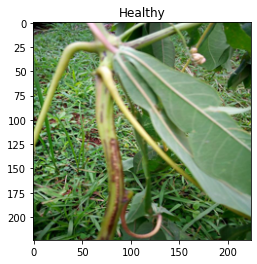

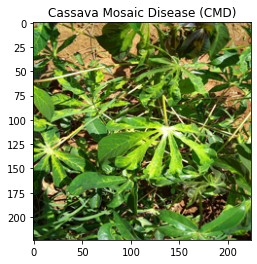

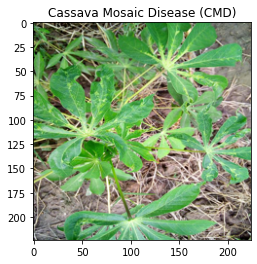

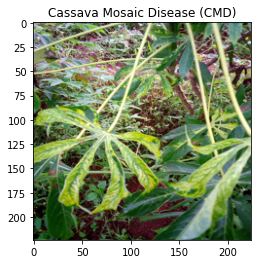

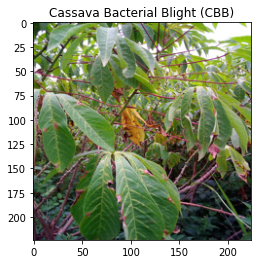

In [ ]:
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  title = class_list[label[0].numpy()]
  plt.title(title)
  plt.show()

## modeling

In [ ]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [ ]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
427/427 [==============================] - 47s 59ms/step - loss: 1.0908 - accuracy: 0.6247 - val_loss: 0.9844 - val_accuracy: 0.6388
Epoch 2/20
427/427 [==============================] - 24s 41ms/step - loss: 0.9657 - accuracy: 0.6471 - val_loss: 0.9198 - val_accuracy: 0.6537
Epoch 3/20
427/427 [==============================] - 23s 41ms/step - loss: 0.9072 - accuracy: 0.6626 - val_loss: 0.9121 - val_accuracy: 0.6650
Epoch 4/20
427/427 [==============================] - 24s 40ms/step - loss: 0.8643 - accuracy: 0.6802 - val_loss: 0.8490 - val_accuracy: 0.6715
Epoch 5/20
427/427 [==============================] - 23s 40ms/step - loss: 0.8249 - accuracy: 0.6920 - val_loss: 0.9282 - val_accuracy: 0.6586
Epoch 6/20
427/427 [==============================] - 23s 40ms/step - loss: 0.7933 - accuracy: 0.6992 - val_loss: 0.7913 - val_accuracy: 0.6984
Epoch 7/20
427/427 [==============================] - 23s 41ms/step - loss: 0.7624 - accuracy: 0.7119 - val_loss: 0.8141 - val_accuracy: